
表格中的每一行都独立于其他行，他们的顺序页没有任何关系。并且，没有提供有关行之前和行之后的列编码信息。


时间序列：我们切换到另一个有趣的数据集：华盛顿特区自行车共享系统中的数据，报告了2011年至2012年之间首都自行车共享系统中租用自行车的每小时计数以及相应的天气和季节性信息。

In [304]:
import pandas as pd
import torch 
import numpy as np

### 加载vsc 创建tensor

In [305]:
dset_path = r"./data/chapter3/hour-fixed.csv" 

In [306]:
# 用pandas预览一下
df = pd.read_csv(dset_path)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [307]:
# 保存col_name
col_name = df.columns
col_name

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

#### 2D转化为3D的张量 ： NxCxL顺序（某日期/某数据/某小时） 
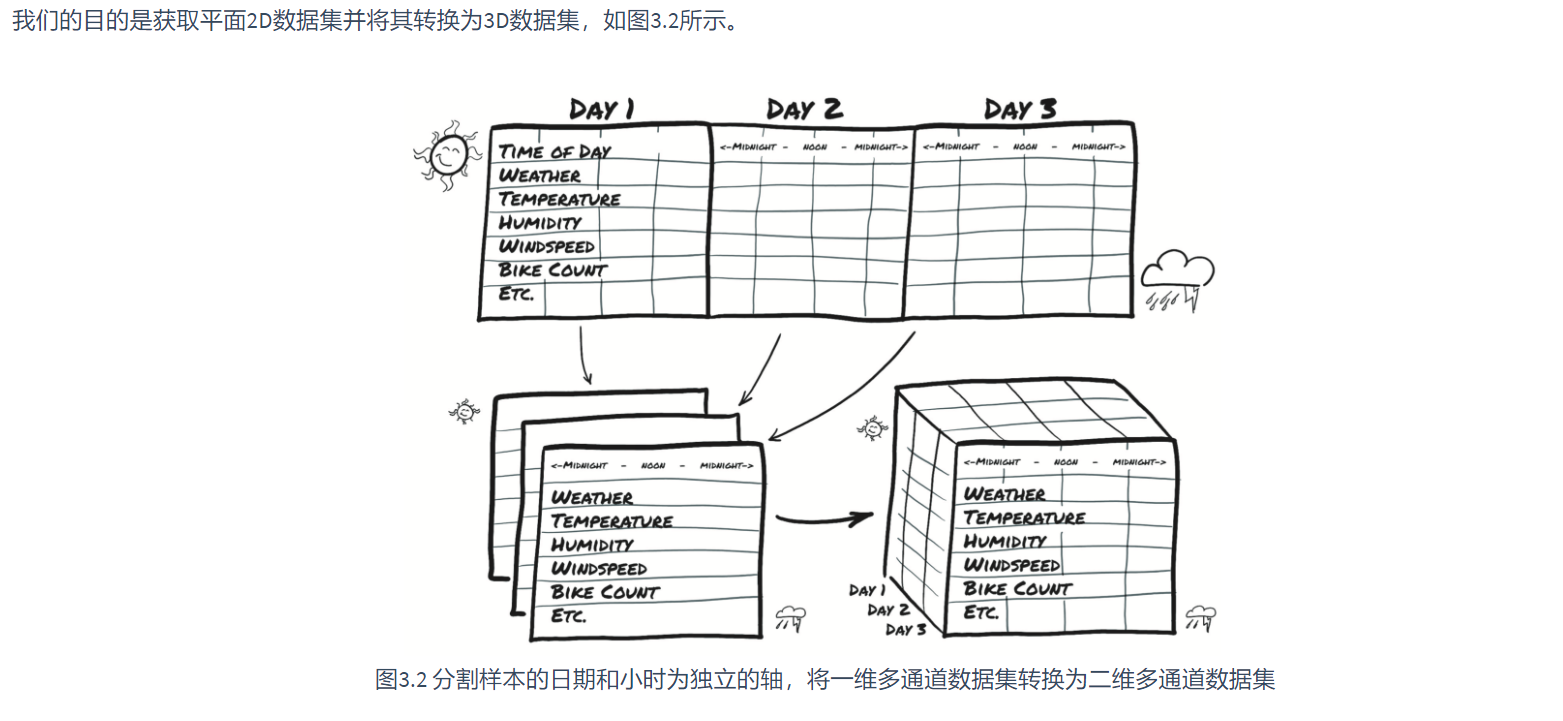

In [308]:
bikes_numpy = np.loadtxt(dset_path,
                         dtype=np.float32,
                         delimiter=",",
                         skiprows=1,
                         converters={1: lambda x: float(x[8:10])}  
                        )
        # 备注converters参数是字典，将某列的数据替换
            # 上述的作用相当于替换为float('2011-01-01'[8:10]) => 01. 也就是day。
                # 如果不转换 error: could not convert string to float: '2011-01-01'
bikes = torch.from_numpy(bikes_numpy) 
bikes

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

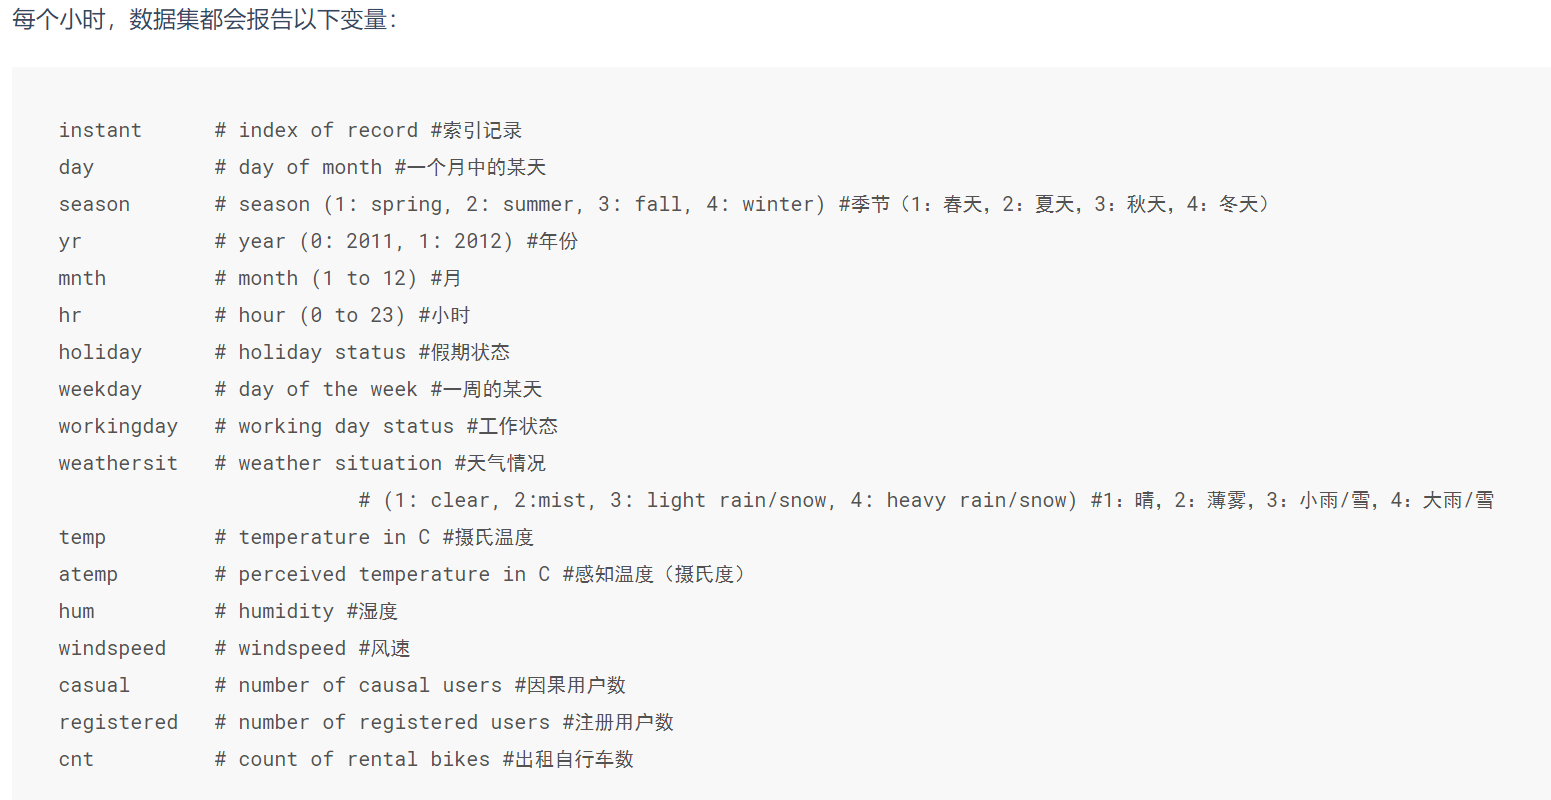

时间序列是指将某种现象某一个统计指标在不同时间上的各个数值，按时间先后顺序排列而形成的序列。时间序列分析的主要目的是根据已有的历史数据对未来进行预测。
- 在此类的时间序列数据集中，行表示连续的时间点：按其排序来制定维度。
    - 这种排序使你有机会利用因果关系去跨越时间.比如通过先前天气情况来预测一次骑行次数

#### 一些说明
- N number of samples 样本数 
    - 样本是长度为L的C个序列的集合
- C channel 通道
- L length 长度或者也叫通道。

举个例子： 在上述的情况中，每个小时记录一行，每行有17列数据值。我需要将数据从2D改为3D。
- 2D = N * C ：每一行看作一个样本，且每行有17列的数据值，所以有样本数N=17520，每个样本有通道数C=17。
- 3D = N * L * C : 每24行看作一个样本N，那么样本数N=17520/24，每个样本就是长度L=24，且每个长度下有通道C=17的并行序列。 目前时间序列NxLxC(某日期/某小时/某数据） 

In [309]:
# 原始数据是2D的，每隔1小时记录一行。
# 当前数据有17520行，17列 。也就是记录了17520小时的各项数据。
bikes.shape,bikes.stride()

(torch.Size([17520, 17]), (17, 1))

In [310]:
# 转为3D数据 。三个轴分别为(日期、小时、17列)
daily_bikes = bikes.view(-1,24,bikes.shape[1]) # -1用作占位符,填充自动计算的结果。
    # 这里只是改变了视图view，内部存储（Storage）不变，依然是连续的数字的线性容器——浮点数
daily_bikes.shape,daily_bikes.stride()
    

(torch.Size([730, 24, 17]), (408, 17, 1))

#### 转置
当前的时间序列数据集是维度为3的张量，形状为NxLxC（某日期/某小时/某数据值）

我们将其转置为NxCxL顺序（某日期/某数据/某小时） 

In [311]:
 # dim=1 dim=2的转置
daily_bikes = torch.transpose(daily_bikes,dim0=1,dim1=2)
daily_bikes.shape,daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

#### 独热编码
天气状况变量是有序数，它有4个等级：1表示最佳天气，而4表示最坏的天气。
将其选择为分类，并将变量转换为独热编码的向量，并将列与数据集连接起来。

In [312]:
# 首先，创建零张量。
    # daily_bikes的形状为（N,C,L），由于4个等级，那么这个零张量的形状为(N,4,L)
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4,daily_bikes.shape[2]) 
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [313]:
# 然后，独热编码散布到C维中的张量中。由于操作是在原地执行的，因此张量的内容会更改
    # 独热编码的在接下来有解释。
daily_weather_onehot.scatter_(1,daily_bikes[:,9,:].long().unsqueeze(1)-1,1.0)
daily_weather_onehot.shape 

torch.Size([730, 4, 24])

In [314]:
# 最后，沿着C维度连接 上述两个张量
daily_bikes = torch.cat((daily_bikes,daily_weather_onehot),dim=1)

---
### 关于scatter函数解释

#### dim=0情况分析    out_tensor[ index_tensor[i][j] ][j] == src_tensor[i][j]
- 参考来源https://www.cnblogs.com/dogecheng/p/11938009.html

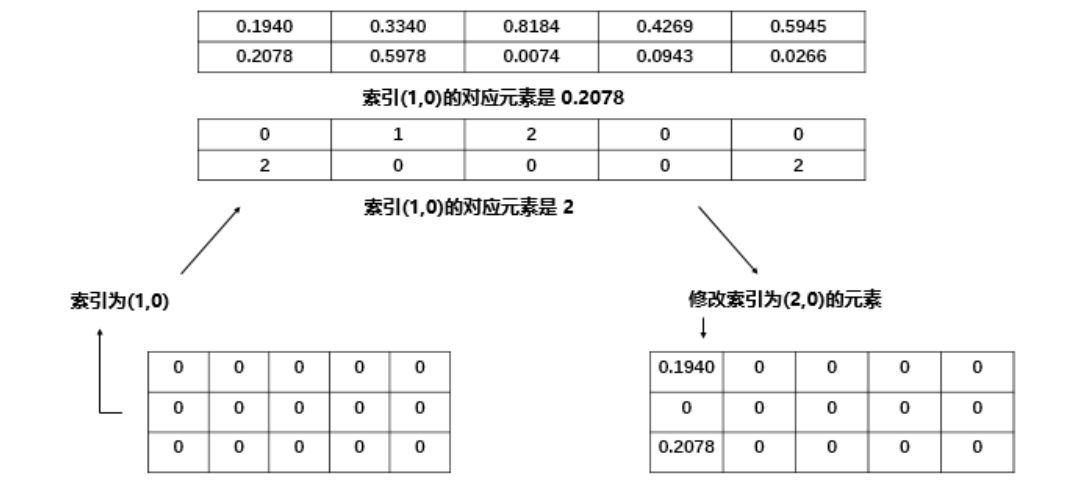

.scatter_(input, dim, index, src) → Tensor
- 将src中的所有值按照index确定的索引写入本tensor中。其中索引是根据给定的dimension，dim按照gather()描述的规则来确定。src 除了可以是张量外，也可以是一个标量

dim=0
- out_tensor[ index_tensor[i][j] ][j] == src_tensor[i][j]

dim=1
- out_tensor[i][ index_tensor[i][j] ] == src_tensor[i][j]

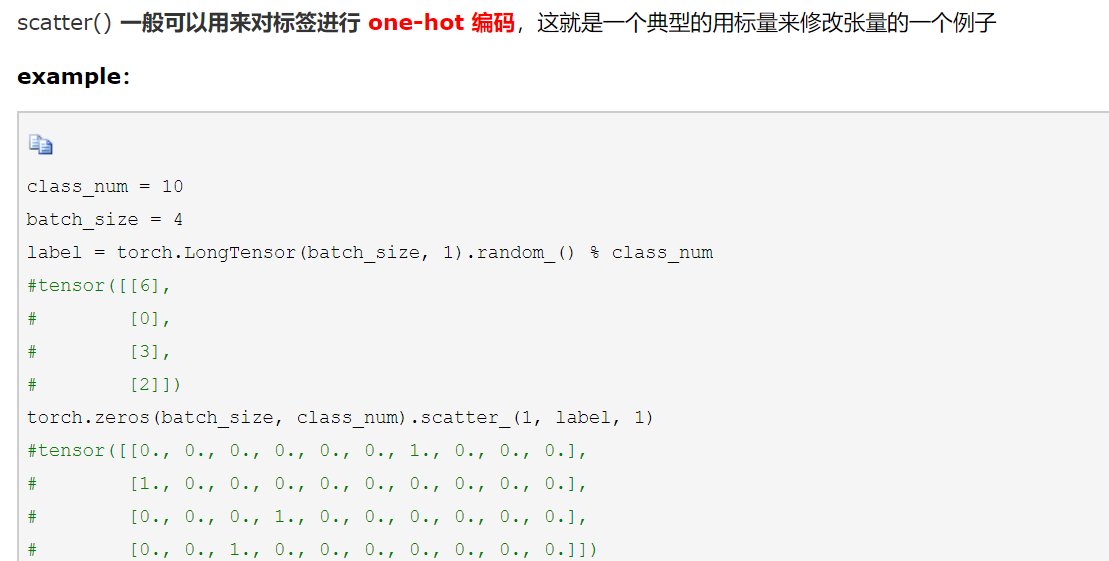

### unsqueeze()解释

In [315]:
a = torch.zeros(2,3) 
b = a.unsqueeze(dim=1) # 向dim=1的维度插入一个维度
a,b,a.shape,b.shape

(tensor([[0., 0., 0.],
         [0., 0., 0.]]),
 tensor([[[0., 0., 0.]],
 
         [[0., 0., 0.]]]),
 torch.Size([2, 3]),
 torch.Size([2, 1, 3]))

---
### 继续

In [316]:
# 用pd看下预览张量
# pd.DataFrame(daily_bikes.numpy()) #出现错误： Must pass 2-d input 。因为这里是3D input


之前用了标签的分类，并使用了独热编码。

但是这里的标签也具有序数关系，我们可以转换变量，使其从0.0到1.0运行：

In [317]:
# 简单的转变天气变量
# daily_bikes[:, 9, :] = (daily_bikes[:, 9, :] - 1.0) / 3.0

In [319]:
# 归一化（特征缩放）的方式的转变天气变量
temp = daily_bikes[:, 9, :] 
daily_bikes[:, 9, :] = (daily_bikes[:, 9, :] - torch.mean(temp)) / torch.std(temp)